# Demo of RtDeep

We define a simple network using RtDeep with microcircuits.

2 kinds of tasks:
- learn to adapt the backward weights to transpose of forward weights <<< this notebook
- learn to reproduce output of a teacher network.

The model uses real time dynamics with Euler integration, LE, dendritic error propagation and a phased implementation of L-DRL.

## Definitions

In [1]:
%matplotlib widget

import numpy as np
import pylab as plt
plt.rc('text', usetex=True)
plt.rc('font', size=12,family='serif')
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from microcircuit import *
import sys
# import pandas as pd


#load autoreload, which automatically reloads the microcircuit.py upon execution
%reload_ext autoreload
%autoreload 1
%aimport microcircuit

# Learn $B = W^+$ in small net

We add tiny noise to the hidden layer in a network [2-2-2] and learn the backwards weights to align with $(W^\mathrm{PP})^+$.

In particular, to make it easier to identify if the task is performed succesfully, we initialise $B^\mathrm{PP}$ with negative entries, and $(W^\mathrm{PP})$ with positive values.

### Setup

In [620]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 1 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 25000 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [0.1]

# np.random.seed(98723)
np.random.seed(325551) #<< this seed doesn't work well, investigate
# np.random.seed(6128736)

# Init model: weights, voltages

layers = [2, 2, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [400.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # we init in SPS
eta_PI = [200.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [0e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively
    # BPP_init.append(np.linalg.pinv(WPP_init[i]))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(1, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=False, noise_mode='uP', model='DTPDRL',
                         activation=relu, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc1.set_self_predicting_state()

In [621]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

-0.21898740104331785

### Simulation

In [622]:
# pre-training to settle voltages -- if we don't do this, weights learn incorrectly due to the incorrect voltages in the beginning
for i in range(int(Tpres/dt)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [623]:
# mc1.init_record(rec_per_steps=1, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=True, rec_rP_breve=True, rec_rP_breve_HI=True, rec_vapi=True, rec_noise=True)

# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
#     # mc1.set_self_predicting_state()

In [624]:
mc1.init_record(rec_per_steps=1000, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=False, rec_rP_breve=False, rec_rP_breve_HI=False, rec_vapi=False)

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc1.set_self_predicting_state()

KeyboardInterrupt: 

In [ ]:
# fig = plt.figure()
# for i in range(len(mc1.vapi_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.vapi_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# vapi_in = []
# for j in range(len(mc1.rP_breve_time_series)):
#         vapi_in.append(mc1.BPP_time_series[j][-1] @ mc1.rP_breve_time_series[j][-1] + mc1.BPI_time_series[j][-1] @ mc1.rI_breve_time_series[j][-1])
# for i in range(len(vapi_in[0])):
#     vec = [vec[i] for vec in vapi_in]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi pre-noise injection layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())

#     vec = [vec[0][i] for vec in mc1.rI_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve/rIbreve layer 2")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_HI_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreveHI in layer 2")
# plt.show()

In [ ]:
# cos = []

# for i in range(len(mc1.noise_time_series)):
#     cos.append(cos_sim(mc1.noise_time_series[i][0], mc1.BPP_time_series[i][-1] @ mc1.rP_breve_HI_time_series[i][-1]))

In [ ]:
# np.mean(cos)

In [ ]:
# plt.figure()
# plt.plot(cos)
# plt.show()

Check that BPP and BPI learn at ~ same speed:

In [407]:
print(mc1.dWIP)
print(mc1.dBPI)
print(mc1.dBPP)

[array([[-0., -0.],
       [ 0.,  0.]])]
[array([[ 1.36612165e-06,  1.43214114e-06],
       [-3.74871881e-05, -3.92988020e-05]])]
[array([[ 1.90383957e-07, -1.12360225e-07],
       [-5.25569375e-06,  3.10178935e-06]])]


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [408]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
# mc1.cos_WIP_WPP = []
# for i in range(len(mc1.WIP_time_series[0])):
#     mc1.cos_WIP_WPP.append(np.array([
#         cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
#                            ]))
    
mc1.cos_WPPpinv_BPP = []
for i in range(len(mc1.BPP_time_series[0])):
    mc1.cos_WPPpinv_BPP.append(np.array([
        cos_sim(mc1.BPP_time_series[j][i], np.linalg.pinv(mc1.WPP[i+1])) for j in range(0, len(mc1.BPP_time_series), STEPS)
                           ]))

BPP at init:

In [409]:
mc1.BPP_time_series[0][0]

array([[-0.05930032, -0.48974386],
       [-0.42750574, -0.35405048]])

In [410]:
print(mc1.rP_breve[1],mc1.rI_breve[-1])
print(mc1.rP_breve[1]-mc1.rI_breve[-1])
print(mc1.BPP[-1] @ mc1.rP_breve[1] + mc1.BPI[-1] @ mc1.rI_breve[-1])

[0.23912789 0.25063988] [0.23910917 0.2506454 ]
[ 1.87110693e-05 -5.52246678e-06]
[-2.78639116e-05  7.64599388e-04]


BPP after learning:

In [411]:
mc1.BPP_time_series[-1][0]

array([[ 5.7251356 , -4.51412498],
       [-2.4783299 ,  7.44499591]])

In [412]:
-mc1.BPI_time_series[-1][0]

array([[ 5.52548366, -4.32302423],
       [-1.69243448,  6.69187261]])

pinv(WPP) (fixed):

In [413]:
np.linalg.pinv(mc1.WPP[1])

array([[ 1.81519528, -1.43721382],
       [-0.86011908,  2.40820199]])

In [414]:
gapi/(gl+gbas+gapi) * mc1.BPP[-1] @ mc1.WPP[-1] 

array([[0.9976352 , 0.00344736],
       [0.04384173, 1.00243306]])

Angle between BPP and pinv(WPP):

In [415]:
np.arccos(cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1])))*180/np.pi

1.179551730665585

Check how well the inversion applies for a sample:

In [416]:
mc1.BPP[-1] @ mc1.WPP[-1] @ mc1.WPP[0] @ r0_random[0]

array([0.59583869, 3.08518209])

In [417]:
gapi/(gl+gbas+gapi) * mc1.BPP[-1] @ mc1.WPP[-1]

array([[0.9976352 , 0.00344736],
       [0.04384173, 1.00243306]])

In [418]:
gbas/(gl+gbas+gapi) * mc1.WPP[0] @ r0_random[-1]

array([0.09751324, 0.5072633 ])

In [419]:
mc1.rP_breve[0]

array([0.09582242, 0.51734768])

In [420]:
gbas/(gl+gbas) * mc1.WPP[1] @ mc1.rP_breve[0]

array([0.23904857, 0.25063097])

In [421]:
mc1.rP_breve[1]

array([0.23912789, 0.25063988])

Plot cos between $B$ and $W^+$, and actual entries (Note: the algorithm only aligns $B$ with $W^+$ multiplied with a constant set by the conductances)

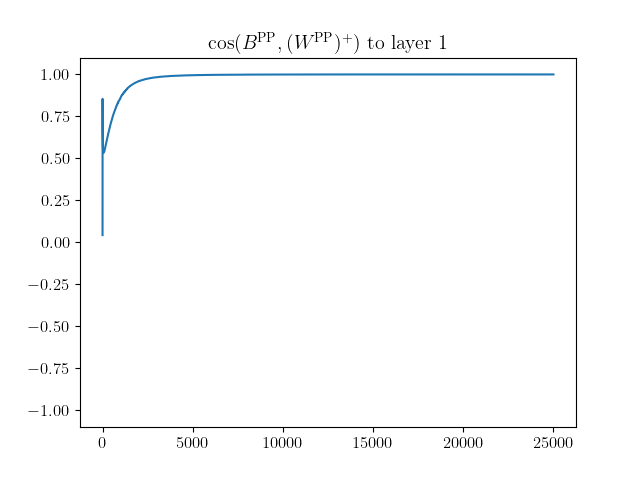

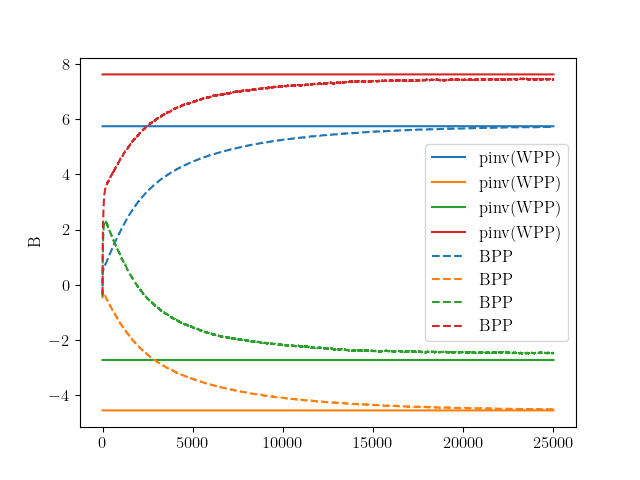

In [422]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WPPpinv_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^+)$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([(gl+gbas+gapi)/gapi *  np.linalg.pinv(mc1.WPP[i+1]).ravel() for BPP in mc1.BPP_time_series], label="pinv(WPP)")
    plt.gca().set_prop_cycle(None)
    ax.plot([BPP[i].ravel() for BPP in mc1.BPP_time_series], label="BPP", ls="--")
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

We also check if the self-predicting state has been learnt correctly:

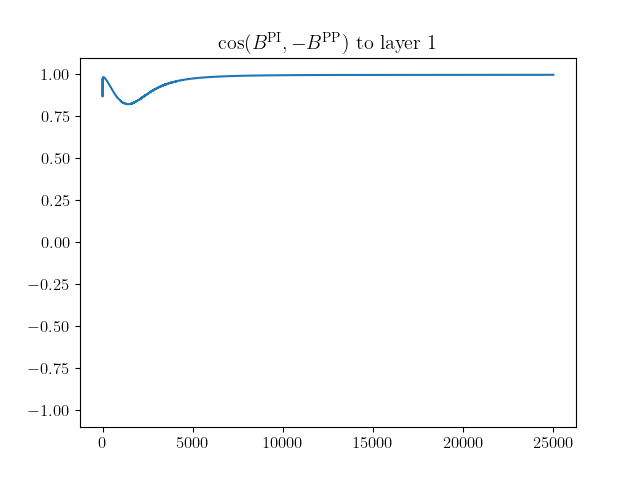

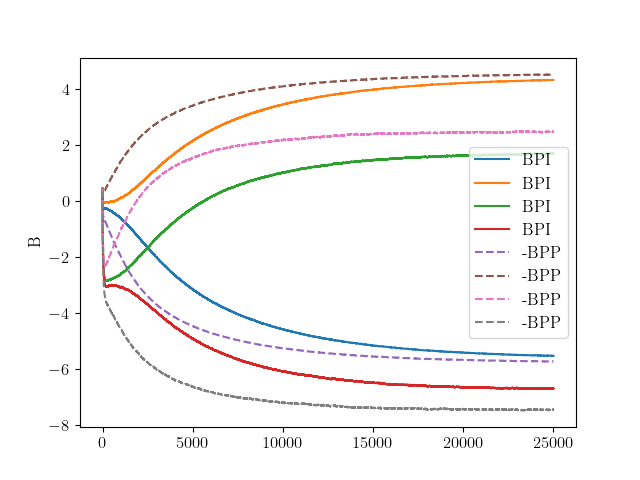

In [423]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP", ls='--')
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [424]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(mc1.cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()

# Learn $B = W^+$ in small net

Another run of the same, this time with [2-3-2].

### Setup

In [564]:
# simulation settings

dt     = 1e-3 # in ms
dtxi   = 10 * dt
tausyn = 1 * dtxi
Tpres  = 1/dt * dt # present images for 1 ms
Tbw    = 1 * Tpres # time scale of phases for backward weight learning
Ttot   = 500 * Tpres # total simulation time

# noise settings: noise_scale is used as vapi + noise where noise = noise_scale * uP
noise_scale = [0.1]

# np.random.seed(98723)
np.random.seed(325551)
# np.random.seed(6128736)

# Init model: weights, voltages

layers = [2, 3, 2]

# conductances
gl = 0.03
gbas = 0.1
gapi = 0.06
gden = 0.1
gnI = 0.06
gntgt = 0.06

# learning rates in 1/ms
eta_fw = [0.0] * (len(layers) - 1)
eta_bw = [500.0] * (len(layers) - 2)
eta_IP = [0.0] * (len(layers) - 1) # we init in SPS
eta_PI = [200.0] * (len(layers) - 1)

# regularizer for backward weight learning
alpha = [0e-5]

# initialise voltages
uP_init = []
for i in range(1, len(layers)):
    uP_init.append(np.random.normal(0, 1, size=layers[i]))
    
uI_init = [np.random.normal(0, 1, size=layers[-1])]
    
# forward pp weights: connects all layers k, k+1
WPP_init = []
for i in range(len(layers)-1):
    WPP_init.append(np.random.uniform(0, 1, size=(layers[i+1], layers[i]))) # << init fw weights positively

# p to inter: connects N-1 to N
WIP_init = [np.random.uniform(-1, 1, size=(layers[-1], layers[-2]))]

# backwards p to p: connects N to k
BPP_init = []
for i in range(1, len(layers)-1):
    BPP_init.append(np.random.uniform(-1, 0, size=(layers[i], layers[-1]))) # << init bw weights negatively
    # BPP_init.append(np.linalg.pinv(WPP_init[i]))

# backwards inter to p: connects N to k
BPI_init = []
for i in range(1, len(layers)-1):
    BPI_init.append(np.random.uniform(-1, 1, size=(layers[i], layers[-1])))
    
# input rates: step functions in the form of random inputs held for Tpres

r0_random = np.random.uniform(1, 1, size=(int(Ttot / Tpres), layers[0]))
r0_random = np.repeat(r0_random, int(Tpres / dt), axis=0)

# instantiate the model

mc1 = phased_noise_model(dt, dtxi, tausyn, Tbw, Tpres, noise_scale, alpha, inter_low_pass=False, pyr_hi_pass=True, dWPP_low_pass=False,
                         gate_regularizer=False, noise_mode='uP_adaptive', model='DTPDRL',
                         activation=relu, layers=layers,
                         uP_init=uP_init, uI_init=uI_init,
                         WPP_init=WPP_init, WIP_init=WIP_init, BPP_init=BPP_init, BPI_init=BPI_init,
                         gl=gl, gden=gden, gbas=gbas, gapi=gapi, gnI=gnI, gntgt=gntgt,
                         eta_fw=eta_fw, eta_bw=eta_bw, eta_PI=eta_PI, eta_IP=eta_IP)

mc1.set_self_predicting_state()

In [565]:
cos_sim(mc1.BPP[-1], np.linalg.pinv(mc1.WPP[-1]))

-0.6177317050606562

### Simulation

In [566]:
# pre-training to settle voltages -- if we don't do this, weights learn incorrectly due to the incorrect voltages in the beginning
for i in range(int(Tpres/dt)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=False, learn_bw_weights=False)

In [567]:
# mc1.init_record(rec_per_steps=1, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=True, rec_rP_breve=True, rec_rP_breve_HI=True, rec_vapi=True, rec_noise=True)

# for i in range(len(r0_random)):
#     mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
#     # mc1.set_self_predicting_state()

In [568]:
mc1.init_record(rec_per_steps=1000, rec_WPP=False, rec_WIP=False, rec_BPP=True, rec_BPI=True, rec_rI_breve=False, rec_rP_breve=False, rec_rP_breve_HI=False, rec_vapi=True, rec_vapi_noise=True, rec_epsilon=False, rec_noise=True, rec_epsilon_LO=True)

for i in range(len(r0_random)):
    mc1.evolve_system(r0=r0_random[i], learn_weights=True, learn_bw_weights=True) # << adapt WIP, BPI and BPP
    # mc1.set_self_predicting_state()

In [569]:
# fig = plt.figure()
# for i in range(len(mc1.vapi_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.vapi_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi layer 1")
# plt.show()

# fig = plt.figure()
# vapi_in = []
# for j in range(len(mc1.rP_breve_time_series)):
#         vapi_in.append(mc1.BPP_time_series[j][-1] @ mc1.rP_breve_time_series[j][-1] + mc1.BPI_time_series[j][-1] @ mc1.rI_breve_time_series[j][-1])
# for i in range(len(vapi_in[0])):
#     vec = [vec[i] for vec in vapi_in]
#     plt.plot(np.array(vec).ravel())
# plt.title("vapi pre-noise injection layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][0])):
#     vec = [vec[0][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve layer 1")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_time_series]
#     plt.plot(np.array(vec).ravel())

#     vec = [vec[0][i] for vec in mc1.rI_breve_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreve/rIbreve layer 2")
# plt.show()

# fig = plt.figure()
# for i in range(len(mc1.rP_breve_time_series[0][1])):
#     vec = [vec[1][i] for vec in mc1.rP_breve_HI_time_series]
#     plt.plot(np.array(vec).ravel())
# plt.title("rPbreveHI in layer 2")
# plt.show()

In [570]:
# cos = []

# for i in range(len(mc1.noise_time_series)):
#     cos.append(cos_sim(mc1.noise_time_series[i][0], mc1.BPP_time_series[i][-1] @ mc1.rP_breve_HI_time_series[i][-1]))

In [571]:
# np.mean(cos)

In [572]:
# plt.figure()
# plt.plot(cos)
# plt.show()

Check that BPP and BPI learn at ~ same speed:

In [573]:
print(mc1.dWIP)
print(mc1.dBPI)
print(mc1.dBPP)

[array([[ 0.,  0.,  0.],
       [-0., -0., -0.]])]
[array([[-2.41581567e-05, -4.13223065e-05],
       [-7.65870131e-06, -1.31001386e-05],
       [ 2.54811064e-05,  4.35851998e-05]])]
[array([[ 1.34667728e-06, -1.86379277e-06],
       [ 2.37283722e-07, -3.28399159e-07],
       [-8.31238543e-07,  1.15042885e-06]])]


Now, let's also check that BPI has converged onto -BPP and WIP onto WPP:

In [574]:
STEPS = 1

mc1.cos_BPI_BPP = []
for i in range(len(mc1.BPI_time_series[0])):
    mc1.cos_BPI_BPP.append(np.array([
        cos_sim(mc1.BPI_time_series[j][i], -mc1.BPP_time_series[j][i]) for j in range(0, len(mc1.BPI_time_series), STEPS)
                           ]))
    
# mc1.cos_WIP_WPP = []
# for i in range(len(mc1.WIP_time_series[0])):
#     mc1.cos_WIP_WPP.append(np.array([
#         cos_sim(mc1.WIP_time_series[j][i], mc1.WPP_time_series[j][i+1]) for j in range(0, len(mc1.WIP_time_series), STEPS)
#                            ]))
    
mc1.cos_WPPpinv_BPP = []
for i in range(len(mc1.BPP_time_series[0])):
    mc1.cos_WPPpinv_BPP.append(np.array([
        cos_sim(mc1.BPP_time_series[j][i], np.linalg.pinv(mc1.WPP[i+1])) for j in range(0, len(mc1.BPP_time_series), STEPS)
                           ]))

BPP at init:

In [575]:
mc1.BPP_time_series[0][0]

array([[-0.60254673, -0.06059137],
       [-0.53275313, -0.30424957],
       [-0.4368076 ,  0.13423144]])

In [576]:
print(mc1.rP_breve[1],mc1.rI_breve[-1])
print(mc1.rP_breve[1]-mc1.rI_breve[-1])
print(mc1.BPP[-1] @ mc1.rP_breve[1] + mc1.BPI[-1] @ mc1.rI_breve[-1])

[0.22293823 0.38134744] [0.22293902 0.38134437]
[-7.91589622e-07  3.06756102e-06]
[ 0.00052025  0.00016499 -0.00054892]


BPP after learning:

In [577]:
mc1.BPP_time_series[-1][0]

array([[ 0.00589576,  0.09306435],
       [-0.17917695,  0.01093662],
       [-0.34248164,  1.47714332]])

pinv(WPP) (fixed):

In [578]:
np.linalg.pinv(mc1.WPP[1])

array([[ 1.76956002, -0.23329165],
       [ 0.81914361,  0.12803089],
       [-0.5175627 ,  1.2273765 ]])

Plot cos between $B$ and $W^+$, and actual entries (Note: the algorithm only aligns $B$ with $W^+$ multiplied with a constant set by the conductances)

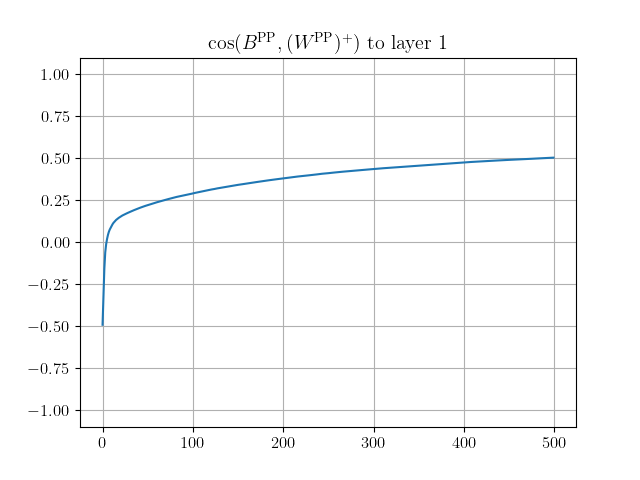

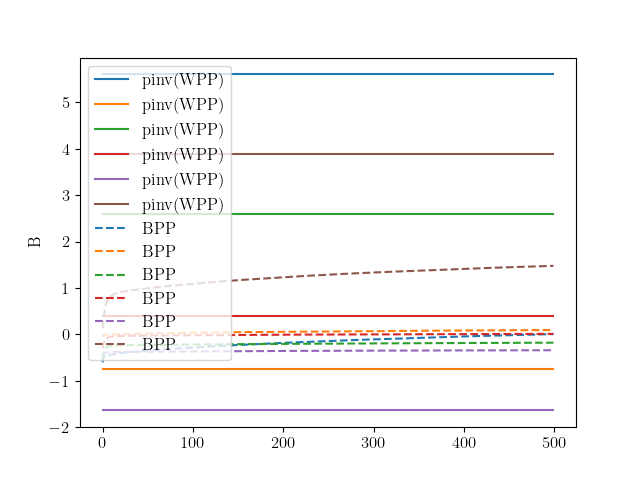

In [579]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_WPPpinv_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PP}, (W^\mathrm{PP})^+)$ to layer ' + str(i+1))
    plt.grid()
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([(gl+gbas+gapi)/gapi *  np.linalg.pinv(mc1.WPP[i+1]).ravel() for BPP in mc1.BPP_time_series], label="pinv(WPP)")
    plt.gca().set_prop_cycle(None)
    ax.plot([BPP[i].ravel() for BPP in mc1.BPP_time_series], label="BPP", ls="--")
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

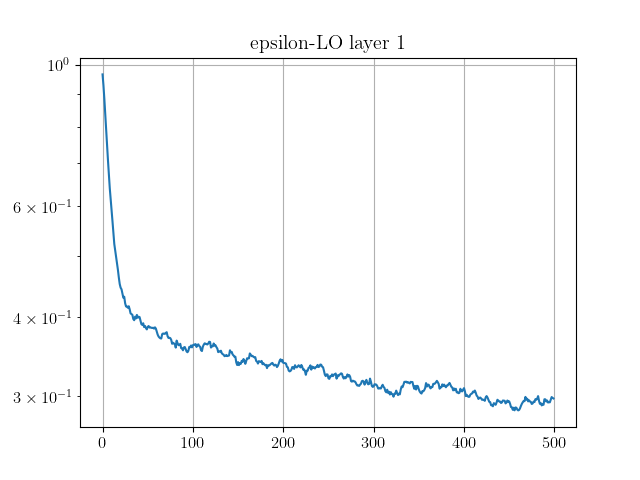

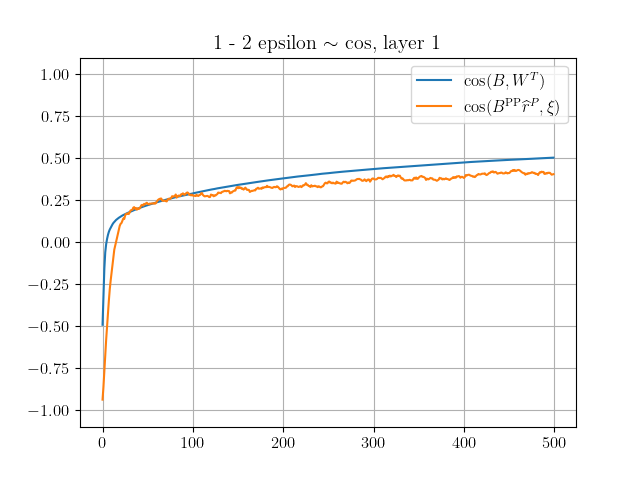

In [580]:
fig = plt.figure()
plt.plot(np.array(mc1.epsilon_LO_time_series).ravel())
# plt.plot(moving_average(np.array(mc1.epsilon_time_series).ravel(), 100))
plt.title("epsilon-LO layer 1")
plt.yscale("log")
plt.grid()
plt.show()

fig = plt.figure()
# plt.plot(1-2*np.array(mc1.epsilon_time_series).ravel())
plt.plot(mc1.cos_WPPpinv_BPP[0], label="$\cos(B, W^T)$")
# plt.plot(moving_average(1-2*np.array(mc1.epsilon_time_series).ravel(), 1000), label="$\\cos(B^\\mathrm{PP}\\widehat{r}^P, \\xi)$")
plt.plot(1-2*np.array(mc1.epsilon_LO_time_series).ravel(), label="$\\cos(B^\\mathrm{PP}\\widehat{r}^P, \\xi)$")
plt.title("1 - 2 epsilon $\sim$ cos, layer 1")
# plt.yscale("log")
plt.legend()
plt.grid()
plt.ylim(-1.1,1.1)
plt.show()

Investigate signal to noise ratio over time:

In [581]:
mc1.noise

[array([ 0.00644483,  0.00106399, -0.00499919]), array([0., 0.])]

In [582]:
mc1.vapi_noise

[array([ 0.00698664,  0.00123575, -0.00557067])]

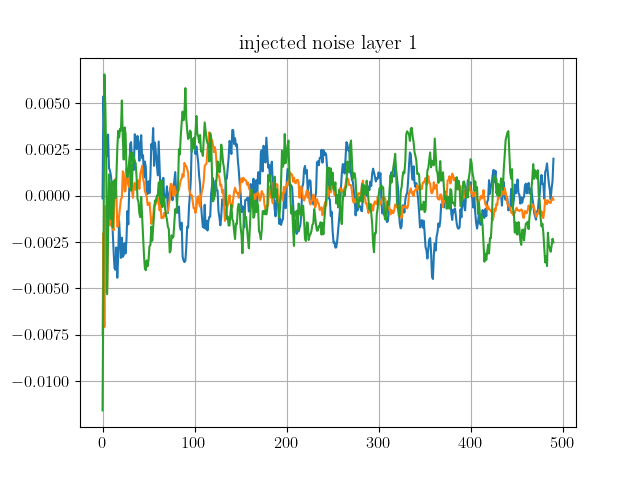

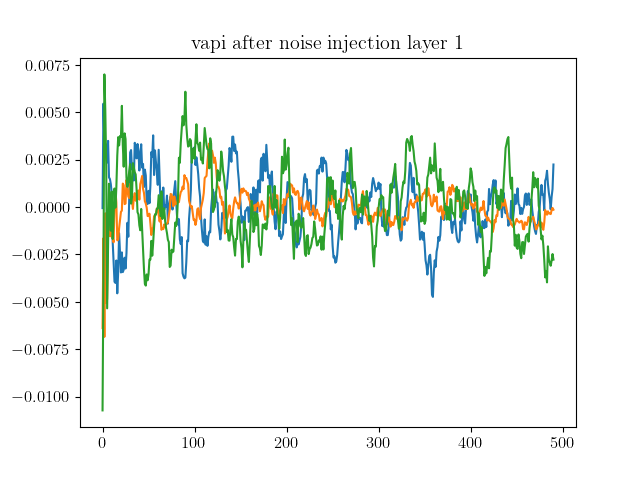

In [583]:
fig = plt.figure()
# plt.plot(np.array([vec[0] for vec in mc1.noise_time_series]))
for i in range(len(mc1.noise_time_series[0][0])):
    plt.plot(moving_average(np.array([vec[0][i] for vec in mc1.noise_time_series]), 10))
plt.title("injected noise layer 1")
plt.grid()
plt.show()

fig = plt.figure()
for i in range(len(mc1.vapi_noise_time_series[0][0])):
    vec = [vec[0][i] for vec in mc1.vapi_noise_time_series]
    plt.plot(moving_average(np.array(vec), 10))
plt.title("vapi after noise injection layer 1")
plt.show()

We also check if the self-predicting state has been learnt correctly:

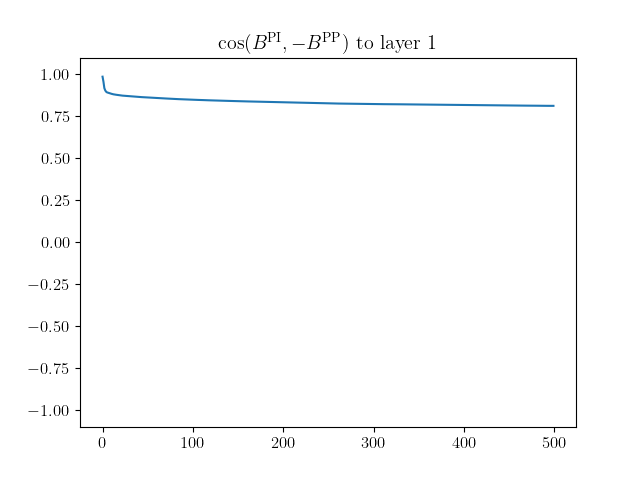

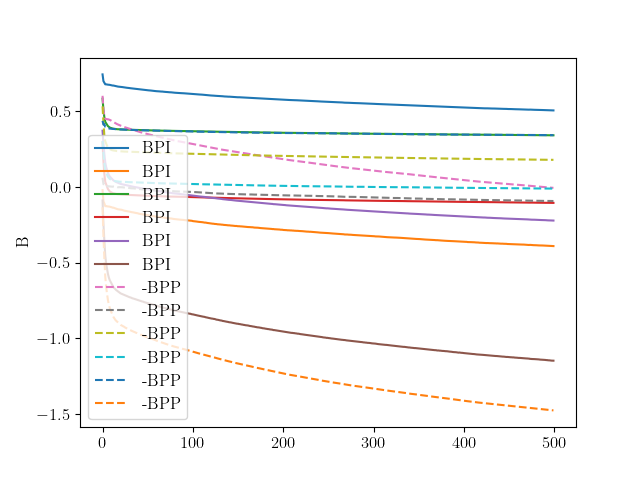

In [584]:
for i in range(len(layers[1:-1])):
    fig, ax = plt.subplots()
    ax.plot(mc1.cos_BPI_BPP[i])
    plt.yscale('linear')
    # label = '10 dt'
    # plt.xlabel(label)
    plt.title('$\cos(B^\mathrm{PI}, -B^\mathrm{PP})$ to layer ' + str(i+1))
    plt.ylim(-1.1,1.1)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.plot([BPI[i].ravel() for BPI in mc1.BPI_time_series], label="BPI")
    ax.plot([-BPP[i].ravel() for BPP in mc1.BPP_time_series], label="-BPP", ls='--')
    plt.yscale('linear')
    # label = 'dt'
    # plt.xlabel(label)
    plt.ylabel("B")
    plt.legend()
    # plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
    plt.show()

In [585]:
# for i in range(len(layers[1:-1])):
#     fig, ax = plt.subplots()
#     ax.plot(mc1.cos_WIP_WPP[i])
#     plt.yscale('linear')
#     label = '10 dt'
#     plt.xlabel(label)
#     plt.title('$\cos(W^\mathrm{IP}, W^\mathrm{PP})$ to layer ' + str(i+1))
#     plt.ylim(-1.1,1.1)
#     plt.show()


# fig, ax = plt.subplots()
# ax.plot(np.array([WPP[1] for WPP in WPP_time_series]).ravel())
# ax.plot(np.array(WIP_time_series).ravel())
# plt.yscale('linear')
# label = 'dt'
# # plt.legend()
# plt.xlabel(label)
# plt.show()